In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Transform: normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 504kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.42MB/s]


In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)  # 28x28 -> 28x28
        self.pool = nn.MaxPool2d(2, 2)          # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1) # 14x14 -> 14x14 -> 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def train_model(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    print(f'Test Accuracy: {acc:.2f}%')
    return acc


In [ ]:
ann = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann.parameters(), lr=0.001)

print("\nTraining ANN...")
train_model(ann, train_loader, optimizer, criterion, epochs=5)
ann_acc = test_model(ann, test_loader)



Training ANN...
Epoch [1/5], Loss: 0.4629
Epoch [2/5], Loss: 0.2361
Epoch [3/5], Loss: 0.1723
Epoch [4/5], Loss: 0.1361
Epoch [5/5], Loss: 0.1139
Test Accuracy: 96.59%


In [ ]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

print("\nTraining CNN...")
train_model(cnn, train_loader, optimizer, criterion, epochs=5)
cnn_acc = test_model(cnn, test_loader)



Training CNN...
Epoch [1/5], Loss: 0.2190
Epoch [2/5], Loss: 0.0570
Epoch [3/5], Loss: 0.0391
Epoch [4/5], Loss: 0.0287
Epoch [5/5], Loss: 0.0230
Test Accuracy: 98.98%


In [ ]:
print("\nSummary:")
print(f"ANN Test Accuracy: {ann_acc:.2f}%")
print(f"CNN Test Accuracy: {cnn_acc:.2f}%")



Summary:
ANN Test Accuracy: 96.59%
CNN Test Accuracy: 98.98%


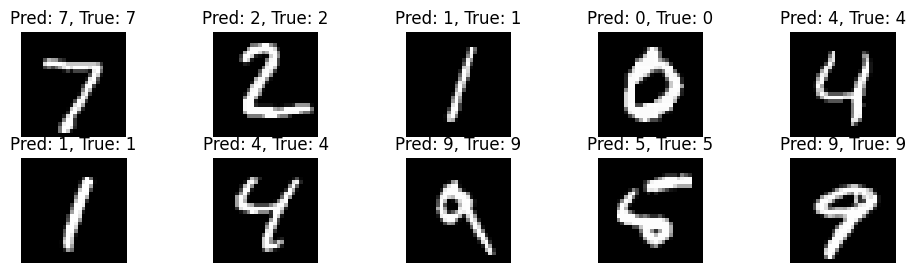

In [ ]:
import numpy as np

cnn.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    output = cnn(images)
_, preds = torch.max(output, 1)

# Show 10 test images with predictions
plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}, True: {labels[i].item()}")
    plt.axis('off')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, test_loader, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.arange(10),
                yticklabels=np.arange(10))
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return cm


📊 Confusion Matrix for ANN:


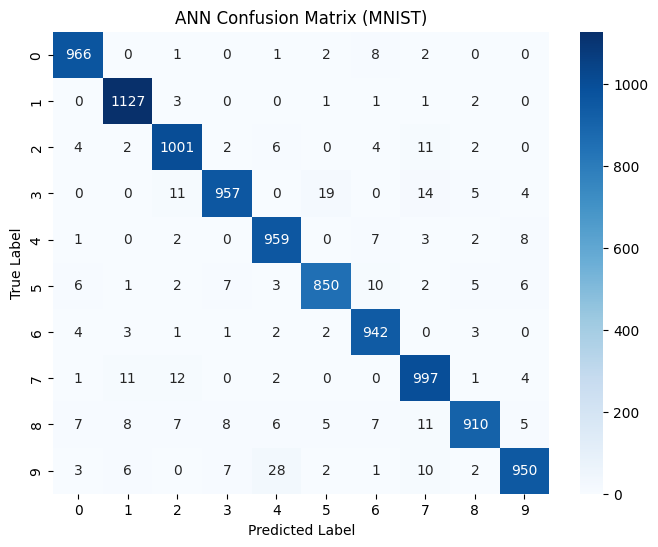

📊 Confusion Matrix for CNN:


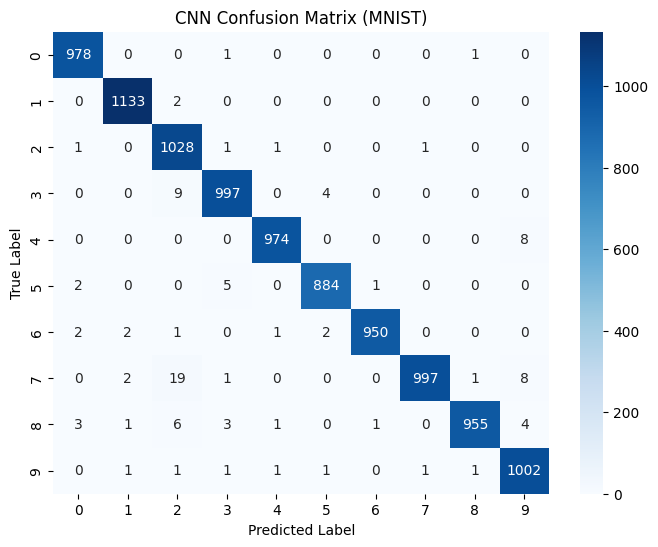

In [ ]:
# Confusion matrix for ANN
print("📊 Confusion Matrix for ANN:")
cm_ann = plot_confusion_matrix(ann, test_loader, title="ANN Confusion Matrix (MNIST)")

# Confusion matrix for CNN
print("📊 Confusion Matrix for CNN:")
cm_cnn = plot_confusion_matrix(cnn, test_loader, title="CNN Confusion Matrix (MNIST)")
